In [1]:
# essentials
import numpy as np
import tensorflow as tf
from tensorflow import keras
from utils.hparams import hparams as hp 
import utils.audio as audio

# misc
import os
import ntpath
import matplotlib.pyplot as plt
import random
from datetime import datetime
import io


2024-05-17 18:34:06.429777: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-17 18:34:06.429809: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-17 18:34:06.429836: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-17 18:34:06.436670: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-17 18:34:07.121947: W tensorflow/compiler/

# Constants

In [2]:
from dotenv import load_dotenv

load_dotenv() # allow using system specific data

CURRENT_EPOCH = 0 # This is to combat kernel crashing 
EPOCHS = 20000
BATCH_SIZE = 100
TEST_BATCH_SIZE = 10
BATCH_DATA_PATH = os.environ.get("BATCH_DATA_PATH")
GENERATED_IMAGES_PATH = os.environ.get("GENERATED_IMAGES_PATH")
SAVED_MODELS_PATH = os.environ.get("SAVED_MODELS_PATH")
DATASET_PATH = os.environ.get("DATASET_PATH")
TEST_DATASET_PATH = os.environ.get("TEST_DATASET_PATH")

# Image and audio settings, must be verified beforehands
IMAGE_SHAPE = (64, 64, 3)
AUDIO_SPECTROGRAM_SHAPE = (4, 601, 1)
MASKED_IMAGE_SHAPE = (32, 64, 3)
# most videos are 10 seconds, so this number line up with the expected frame rate
AVERAGE_FRAME_PER_VIDEO = 217 # number of frames / number of audio files

MODEL_NAME = os.environ.get("MODEL_NAME")

# Load Batch Data
### Pre-determined randomized batches to avoid wasting time randomizing it on the fly.
`BATCH_DATA` is structured as a 3D array (dictionary here but the key is the index so same thing) of size `EPOCHS*BATCH_SIZE*2`.\
Every epoch, `BATCH_DATA` is called to fetch a certain epoch, which returns the array of size `BATCH_SIZE*2`.\
The 2 names corresponds to the name of the image, as well as the reference, where the image is the one we mask and generate based on, while the reference is the reference image of the same face

# Model Input Pipeline

Utilities

In [3]:
def original_image_path_gen(folder_path):
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        if os.path.isfile(file_path):
            yield file_path

In [4]:
def ref_image_path_gen(folder_path):
    """
    Generates reference frame path for each frame in the folder.
    NOTE: this might not work as intended if there are more than 1 person in the video.
    Assumes os.listdir returns the files in the same order (should be the case in most systems).
    Returns: tuple
        path: the path to the reference image
        modify: whether to modify the image (if a reference cannot be found)
    """
    # not a fan of the loop, but it is what it is
    for file in os.listdir(folder_path):
        path = os.path.join(folder_path, file)
        if os.path.isfile(path):
            counter = 0
            video_name, frame_index = file.split("_") # the frame file is <source_video>_<frame_index>
            frame_index = int(frame_index.split(".")[0]) # remove the file extension
            ref_frame_path = path
            ref_frame_index = frame_index
            # find a valid reference frame of the same person. Assumes each video is of a single person.
            while ref_frame_index == frame_index or not os.path.exists(ref_frame_path):
                ref_frame_index = random.randint(0, AVERAGE_FRAME_PER_VIDEO - 1)
                ref_frame_path = os.path.join(folder_path, video_name + "_" + str(ref_frame_index) + ".png")
                counter+=1 # stop once counter reaches 10
                if counter >= 10:
                    yield path, True # return the same image, but we'll flip it
            yield ref_frame_path, False

In [5]:
def crop_audio_window(spectrogram, start_frame_num):
    """
    Get the audio spectrogram window corresponding to the frame.
    """
    # I did some testing, there are 8 samples per second
    start_idx = int(8 * (start_frame_num // hp.fps))
    
    end_idx = start_idx + 4 # half a second to provide some padding
    if (spectrogram.shape[0] < end_idx):
        return spectrogram[-4:, :]

    return spectrogram[start_idx : end_idx, :]

In [6]:
def load_audio_data(image_path, dataset_path):
    """
    Load the audio data from the file.
    """
    image_path = image_path.numpy().decode("utf-8")
    dataset_path = dataset_path.numpy().decode("utf-8")
    frame_name = ntpath.basename(image_path) # get the name without the path (should also work on windows)
    video_name, frame_index = frame_name.split("_") # the frame file is <source_video>_<frame_index>
    frame_index = int(frame_index.split(".")[0]) # remove the file extension

    audio_path = os.path.join(dataset_path, "audio", video_name + ".wav")

    wav = audio.load_wav(audio_path, hp.sample_rate)
    # get the spectrogram, seems inefficient to do this every time
    spectrogram = audio.melspectrogram(wav)
    spectrogram_window = crop_audio_window(spectrogram, frame_index)
    spectrogram_window = tf.expand_dims(spectrogram_window, axis=-1) # add channel dimension
    spectrogram_window = tf.convert_to_tensor(spectrogram_window)
    return spectrogram_window

In [7]:
def load_image(image_path, modify):
    """
    Load the image from the file.
    Args:
        image_path: the path to the image to load
        modify: whether to modify this image TODO
    """
    image_path = image_path.numpy().decode("utf-8")
        
    raw = tf.io.read_file(image_path)
    image = tf.image.decode_png(raw, channels=3)

    image = tf.cast(image, tf.float32) / 255. # [0 - 1] range

    if modify:
        # add any transformations here
        image = tf.image.flip_left_right(image)

    return image

In [8]:
def load_masked_image(original_image):
    # crop out bottom half
    masked_image = original_image[:32, :, :] # strange bug where the height is a [3] tensor
    return masked_image

Creating the Dataset

In [9]:
def batcher_from_directory(batch_size:int, dataset_path:str, shuffle=False,seed=None) -> tf.data.Dataset:
    """
    Return a tensorflow Dataset object that returns images and spectrograms as required.
    Partly inspired by https://github.com/keras-team/keras/blob/v3.3.3/keras/src/utils/image_dataset_utils.py
    
    Args:
        batch_size: The batch size.
        dataset_path: The path to the dataset folder which must contain the image folder and audio folder.
        shuffle: Whether to shuffle the dataset. Default to False.
        seed: The seed for the shuffle. Default to None.
    """
    image_dataset_path = os.path.join(dataset_path, "image")
    # create the foundation datasets
    og_dataset = tf.data.Dataset.from_generator(lambda: original_image_path_gen(image_dataset_path), 
                                                output_signature=tf.TensorSpec(shape=(), dtype=tf.string))
    og_dataset = og_dataset.repeat(None) # repeat indefinitely
    ref_dataset = tf.data.Dataset.from_generator(lambda: ref_image_path_gen(image_dataset_path),
                                                 output_signature=(tf.TensorSpec(shape=(), dtype=tf.string), 
                                                                   tf.TensorSpec(shape=(), dtype=tf.bool)))
    ref_dataset = ref_dataset.repeat(None) # repeat indefinitely

    # create the input datasets
    og_image_dataset = og_dataset.map(lambda x: tf.py_function(load_image, [x, tf.convert_to_tensor(False, dtype=tf.bool)], tf.float32), 
                                        num_parallel_calls=tf.data.AUTOTUNE)
    masked_image_dataset = og_image_dataset.map(lambda x: tf.py_function(load_masked_image, [x], tf.float32),
                                        num_parallel_calls=tf.data.AUTOTUNE)
    ref_image_dataset = ref_dataset.map(lambda x, y: tf.py_function(load_image, [x, y], tf.float32), 
                                        num_parallel_calls=tf.data.AUTOTUNE)
    audio_spec_dataset = og_dataset.map(lambda x: tf.py_function(load_audio_data, [x, dataset_path], tf.float64),
                                        num_parallel_calls=tf.data.AUTOTUNE)
    unsync_spec_dataset = ref_dataset.map(lambda x, _: tf.py_function(load_audio_data, [x, dataset_path], tf.float64),
                                        num_parallel_calls=tf.data.AUTOTUNE)
    
    # ensure shape as tensorflow does not accept unknown shapes
    og_image_dataset = og_image_dataset.map(lambda x: tf.ensure_shape(x, IMAGE_SHAPE))
    masked_image_dataset = masked_image_dataset.map(lambda x: tf.ensure_shape(x, MASKED_IMAGE_SHAPE))
    ref_image_dataset = ref_image_dataset.map(lambda x: tf.ensure_shape(x, IMAGE_SHAPE))
    audio_spec_dataset = audio_spec_dataset.map(lambda x: tf.ensure_shape(x, AUDIO_SPECTROGRAM_SHAPE))
    unsync_spec_dataset = unsync_spec_dataset.map(lambda x: tf.ensure_shape(x, AUDIO_SPECTROGRAM_SHAPE))
    
    # multi input using https://discuss.tensorflow.org/t/train-a-model-on-multiple-input-dataset/17829/4
    full_dataset = tf.data.Dataset.zip((masked_image_dataset, ref_image_dataset, audio_spec_dataset, unsync_spec_dataset), og_image_dataset)
    # if shuffle:
    #     full_dataset = full_dataset.shuffle(buffer_size=batch_size * 8, seed=seed) # not sure why buffer size is such
    
    # batch
    full_dataset = full_dataset.batch(batch_size=batch_size)
    
    return full_dataset

# Dataset
Batch generator technically

In [10]:
x_train = batcher_from_directory(hp.batch_size, DATASET_PATH)
x_test = batcher_from_directory(TEST_BATCH_SIZE, TEST_DATASET_PATH)
x_test.element_spec

2024-05-17 18:34:08.363251: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-17 18:34:08.406497: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-17 18:34:08.406705: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

((TensorSpec(shape=(None, 32, 64, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 4, 601, 1), dtype=tf.float64, name=None),
  TensorSpec(shape=(None, 4, 601, 1), dtype=tf.float64, name=None)),
 TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None))

In [11]:
# test the batcher
x_test_iter = iter(x_test)

Shape of original image:  (64, 64, 3)
Shape of masked image:  (32, 64, 3)
Shape of spectrogram window:  (4, 601, 1)


(-0.5, 63.5, 63.5, -0.5)

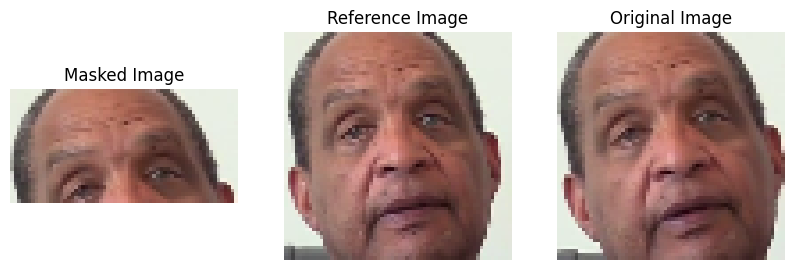

In [12]:
x, original_image = next(x_test_iter)
masked_image, ref_image, spectrogram_window, _ = x

print("Shape of original image: ", original_image[0].shape)
print("Shape of masked image: ", masked_image[0].shape)
print("Shape of spectrogram window: ", spectrogram_window[0].shape)

# plot the images
plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(masked_image[0])
plt.title("Masked Image")
plt.axis("off")
plt.subplot(1, 3, 2)
plt.imshow(ref_image[0])
plt.title("Reference Image")
plt.axis("off")
plt.subplot(1, 3, 3)
plt.imshow(original_image[0])
plt.title("Original Image")
plt.axis("off")

# Model Definition

### Identity Encoders
1 for generator (reference) 1 for discriminator (generated image)

In [13]:
identity_encoder = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=IMAGE_SHAPE, name="ref_image_input"),
    keras.layers.GaussianNoise(0.1), # introduce some noise
    keras.layers.Conv2D(16, 7, 4, padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, 3, 2, padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, 3, 2, padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(256, 3, 2, padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Flatten(name='id_encoding'),
], name="id_encoder")
identity_encoder.summary()

Model: "id_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gaussian_noise (GaussianNo  (None, 64, 64, 3)         0         
 ise)                                                            
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 16)        2368      
                                                                 
 batch_normalization (Batch  (None, 16, 16, 16)        64        
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          9280      
                                                                 
 batch_normalization_1 (Bat  (None, 8, 8, 64)          256       
 chNormalization)                                                
                                                        

In [14]:
# sigmoid ensures euclidean distance is in [0,1]
identity_encoder_disc = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=IMAGE_SHAPE, name="image_input"),
    keras.layers.Conv2D(16, 7, 4, padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, 5, 2, padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, 3, 2, padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, 3, 1, padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Flatten(name='id_encoding_disc'),
], name="id_encoder_disc")
identity_encoder_disc.summary()

Model: "id_encoder_disc"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 16, 16, 16)        2368      
                                                                 
 batch_normalization_4 (Bat  (None, 16, 16, 16)        64        
 chNormalization)                                                
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 64)          25664     
                                                                 
 batch_normalization_5 (Bat  (None, 8, 8, 64)          256       
 chNormalization)                                                
                                                                 
 conv2d_6 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 batch_normalization_6 (Bat  (None, 4, 4, 64)      

### Masked Identity Encoder

In [15]:
masked_id_encoder = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=MASKED_IMAGE_SHAPE, name="masked_image_input"),
    keras.layers.Conv2D(16, 7, 4, padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(32, 5, 2, padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, 3, 2, padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, 1, 1, padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Flatten(name='masked_id_encoding'),
], name="masked_id")
masked_id_encoder.summary()

Model: "masked_id"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 8, 16, 16)         2368      
                                                                 
 batch_normalization_8 (Bat  (None, 8, 16, 16)         64        
 chNormalization)                                                
                                                                 
 conv2d_9 (Conv2D)           (None, 4, 8, 32)          12832     
                                                                 
 batch_normalization_9 (Bat  (None, 4, 8, 32)          128       
 chNormalization)                                                
                                                                 
 conv2d_10 (Conv2D)          (None, 2, 4, 64)          18496     
                                                                 
 batch_normalization_10 (Ba  (None, 2, 4, 64)          25

### Audio Encoder
1 for generator 1 for discriminator

In [16]:
# crazy parameters balooning at the end, but who knows?
audio_encoder = keras.models.Sequential([
    keras.layers.Input(shape=AUDIO_SPECTROGRAM_SHAPE, name="audio_input"),
    keras.layers.Conv2D(16, 7, (2, 6), padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(32, 5, (1, 3), padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, 3, (1, 3), padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, 3, (1, 3), padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Flatten(name='audio_encoding'),
], name="audio_encoder")
audio_encoder.summary()

Model: "audio_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 2, 101, 16)        800       
                                                                 
 batch_normalization_12 (Ba  (None, 2, 101, 16)        64        
 tchNormalization)                                               
                                                                 
 conv2d_13 (Conv2D)          (None, 2, 34, 32)         12832     
                                                                 
 batch_normalization_13 (Ba  (None, 2, 34, 32)         128       
 tchNormalization)                                               
                                                                 
 conv2d_14 (Conv2D)          (None, 2, 12, 64)         18496     
                                                                 
 batch_normalization_14 (Ba  (None, 2, 12, 64)       

In [17]:
# sigmoid ensures euclidean distance is in [0,1]
audio_encoder_disc = keras.models.Sequential([
    keras.layers.Input(shape=AUDIO_SPECTROGRAM_SHAPE, name="audio_input"),
    keras.layers.Conv2D(16, 7, (2, 6), padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(32, 5, (1, 3), padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, 3, (1, 3), padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, 3, (1, 3), padding='same', activation='sigmoid'), 
    keras.layers.BatchNormalization(),
    keras.layers.Flatten(name='audio_encoding_disc'),
], name="audio_encoder_disc")
audio_encoder_disc.summary()

Model: "audio_encoder_disc"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 2, 101, 16)        800       
                                                                 
 batch_normalization_16 (Ba  (None, 2, 101, 16)        64        
 tchNormalization)                                               
                                                                 
 conv2d_17 (Conv2D)          (None, 2, 34, 32)         12832     
                                                                 
 batch_normalization_17 (Ba  (None, 2, 34, 32)         128       
 tchNormalization)                                               
                                                                 
 conv2d_18 (Conv2D)          (None, 2, 12, 64)         18496     
                                                                 
 batch_normalization_18 (Ba  (None, 2, 12, 64)  

### Deepfake Decoder

In [18]:
# verify the latent dimensions using the models above
latent_dims = 1024+512+1024
decoder = keras.models.Sequential([
    # the comma makes tensorflow interpret latent_dims as a valid shape
    keras.layers.Input(shape=(latent_dims, ), name="deepfake_encoding"),
    keras.layers.Reshape((4, 4, 160)), # 4x4x160 = 2560
    keras.layers.Conv2DTranspose(128, 3, (1, 2), padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, 3, 2, padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(32, 3, 2, padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(16, 3, 2, padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(3, 1, 1, padding='same', activation='sigmoid'),
], name='face_decoder')
decoder.summary()

Model: "face_decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 4, 4, 160)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 4, 8, 128)         184448    
 anspose)                                                        
                                                                 
 batch_normalization_20 (Ba  (None, 4, 8, 128)         512       
 tchNormalization)                                               
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 8, 16, 64)         73792     
 Transpose)                                                      
                                                                 
 batch_normalization_21 (Ba  (None, 8, 16, 64)         256       
 tchNormalization)                                    

### Autoencoder

In [19]:
class Generator(keras.Model):
    """The auto encoder stack represening the generator"""
    def __init__(self, masked_id_encoder, reference_id_encoder, audio_encoder, decoder):
        super().__init__()
        self.masked_id_encoder = masked_id_encoder
        self.reference_id_encoder = reference_id_encoder
        self.audio_encoder = audio_encoder
        self.decoder = decoder

    def call(self, x):
        identity, reference, audio = x 
        id_encoding = self.masked_id_encoder(identity)
        ref_encoding = self.reference_id_encoder(reference)
        audio_encoding = self.audio_encoder(audio)
        combined = tf.concat([id_encoding, ref_encoding, audio_encoding], -1) # dimension 0 is batch size
        genenerated_mouth = self.decoder(combined) 
        return tf.concat([identity, genenerated_mouth], axis=-3) # combine generated mouth and original top half

### Discriminator

In [20]:
class Discriminator(keras.Model):
    """Deepfake Discriminator"""
    def __init__(self, image_encoder, audio_encoder):
        super().__init__()
        self.image_encoder = image_encoder
        self.audio_encoder = audio_encoder
    
    def call(self, x):
        image, audio = x
        image_encoding = self.image_encoder(image)
        audio_encoding = self.audio_encoder(audio)

        # L2-normalize the encoding tensors
        image_encoding = tf.math.l2_normalize(image_encoding, axis=1)
        audio_encoding = tf.math.l2_normalize(audio_encoding, axis=1)

        # measures how much the face matches the audio
        # will return nan without the 1e-12 offset due to https://github.com/tensorflow/tensorflow/issues/12071
        return tf.norm((image_encoding - audio_encoding) + 1e-12, ord='euclidean', axis=1, keepdims=True)

### Deepfake GAN

In [21]:
import time 


class DeepfakeGAN(keras.Model):
    """The Deepfake Generative Adversarial Network model."""
    def __init__(self, generator, discriminator):
        """
        Constructor
        Args:
            generator The generator model
            discriminator: The discriminator model
            test_gen_data: The data to generate a constant human face for the gif
        """
        super().__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        """
        Compiles the GAN.
        Args:
            d_optimizer: The optimizer for the discriminator
            g_optimizer: The optimizer for the generator
            d_loss_fn: The loss function for the discriminator
            g_loss_fn: The loss function for the generator
        """
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def call(self, x):
        return self.generator(x)
    
    @tf.function
    def train_step(self, data):
        """
        Trains the GAN for one epoch. Will only train on BATCH_SIZE-1 samples.
        Args:
            data: lists of real images and the audio spectrograms with correspondent indices
        """
        x, original_image = data
        masked_image, ref_image, spectrogram_window, unsync_window = x

        batch_size = tf.shape(original_image)[0]

        # Use the generator to generate images
        generated_images = self.generator((masked_image, ref_image, spectrogram_window))

        train_unsync = tf.random.uniform(()) < 0.5 # 50/50
        if not train_unsync:
            # Add real images to batch
            combined_images = tf.concat(
                [generated_images, original_image], axis=0
                ) 
            combined_audio = tf.concat(
                [spectrogram_window, spectrogram_window], axis=0
                )
        else:
            # Add real images to batch
            combined_images = tf.concat(
                [original_image, original_image], axis=0
                ) 
            combined_audio = tf.concat(
                [unsync_window, spectrogram_window], axis=0
                )
        # Discriminator labels for combined_images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
            )
        labels += 0.05 * tf.random.uniform(tf.shape(labels)) # Add random noise to the labels

        # Train the discriminator
        with tf.GradientTape() as disc_tape:
            predictions = self.discriminator((combined_images, combined_audio))
            d_loss = self.d_loss_fn(labels, predictions)

        # Compute gradients and update weights
        grads = disc_tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # Train the generator
        with tf.GradientTape() as gen_tape:
            # Use the generator to generate images, must be done again to create connection
            generated_images = self.generator((masked_image, ref_image, spectrogram_window))
            predictions = self.discriminator((generated_images, spectrogram_window))
            # Labels if all real images
            real = tf.zeros((batch_size, 1))
            # Staggering loss function as mse is small
            g_loss = hp.disc_wt *(self.d_loss_fn(real, predictions)) + self.g_loss_fn(original_image, generated_images)

        # Compute gradients and update weights
        grads = gen_tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)

        return {
                "gen_loss": self.gen_loss_tracker.result(),
                "disc_loss": self.disc_loss_tracker.result(),
            }
    
    def test_step(self, data):
        x, original_images = data
        masked_image, ref_image, spectrogram_window, _ = x

        batch_size = tf.shape(original_images)[0]

        # inference
        generated_images = self.generator((masked_image, ref_image, spectrogram_window))
        predictions = self.discriminator((generated_images, spectrogram_window))

        # calculate loss
        d_loss = self.d_loss_fn(tf.ones((batch_size, 1)), predictions)
        g_loss = hp.disc_wt *(self.d_loss_fn(tf.zeros((batch_size, 1)), predictions)) + self.g_loss_fn(original_image, generated_images)

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)

        return {
                "test_gen_loss": self.gen_loss_tracker.result(),
                "test_disc_loss": self.disc_loss_tracker.result(),
            }


# Train

In [22]:
generator = Generator(masked_id_encoder, identity_encoder, audio_encoder, decoder)
discriminator = Discriminator(identity_encoder_disc, audio_encoder_disc)
gan = DeepfakeGAN(generator, discriminator)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=hp.disc_initial_learning_rate),
    g_optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    d_loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
    g_loss_fn=keras.losses.MeanAbsoluteError(),
)

In [23]:
# Clear out prior logging data.
!rm -rf logs/image

test_data = next(x_test_iter)

logdir = "logs/image/" + datetime.now().strftime("%Y%m%d-%H%M%S")
# Define the basic TensorBoard callback.
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
file_writer_cm = tf.summary.create_file_writer(logdir + '/cm')

def plot_to_image(figure):
  """Converts the matplotlib plot specified by 'figure' to a PNG image and
  returns it. The supplied figure is closed and inaccessible after this call."""
  # Save the plot to a PNG in memory.
  buf = io.BytesIO()
  plt.savefig(buf, format='png')
  # Closing the figure prevents it from being displayed directly inside
  # the notebook.
  plt.close(figure)
  buf.seek(0)
  # Convert PNG buffer to TF image
  image = tf.image.decode_png(buf.getvalue(), channels=4)
  # Add the batch dimension
  image = tf.expand_dims(image, 0)
  return image

def test_generate(epoch, logs):
  # if epoch % 10 != 0: # only run every 10 epochs
  #   return 
  
  gan.save_weights("trained_models/unsync1000")

  x, original_images = test_data
  masked_image, ref_image, spectrogram_window, _ = x

  # This is so all layers run in inference mode (batchnorm).
  predictions  = gan.generator((masked_image, ref_image, spectrogram_window))
  d = gan.discriminator((predictions, spectrogram_window))
  if tf.is_symbolic_tensor(predictions):
    return

  # if from_tensor:
  #   original_images = original_images.numpy()
  #   masked_image = masked_image.numpy()
  #   # ref_image = ref_image.numpy()
  #   # spectrogram_window = spectrogram_window.numpy()
  #   predictions = predictions.numpy()
  #   d = d.numpy()

  batch_size = original_images.shape[0]

  figure = plt.figure(figsize=(15, 6))
  for i in range(batch_size):
    # display original
    ax = plt.subplot(3, batch_size, i + 1)
    plt.imshow(original_images[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, batch_size, i + 1 + batch_size)
    plt.imshow(ref_image[i])
    plt.title("reference") # only show 3 floating points 
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, batch_size, i + 1 + 2*batch_size)
    plt.imshow(predictions[i])
    plt.title("d=" + str(d[i].numpy()[0])) # only show 3 floating points 
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

  with file_writer_cm.as_default():
    tf.summary.image("Test Generation", plot_to_image(figure), step=epoch)

In [24]:
# Define the per-epoch callback.
cm_callback = keras.callbacks.LambdaCallback(on_epoch_end=test_generate)

In [25]:
gan.load_weights("trained_models/unsync1000")
history = gan.fit(x_train, epochs=200, verbose=1, steps_per_epoch=100, 
                  validation_data=x_test, validation_steps=1, validation_freq=10, callbacks=[tensorboard_callback, cm_callback])

Epoch 1/200


2024-05-17 18:34:21.006003: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-05-17 18:34:23.601171: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7a905fc1c380 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-17 18:34:23.601198: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2024-05-17 18:34:23.605057: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-17 18:34:23.666178: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


100/100 [==============================] - 169s 2s/step - gen_loss: 0.1270 - disc_loss: 0.6634
Epoch 2/200
100/100 [==============================] - 155s 2s/step - gen_loss: 0.1265 - disc_loss: 0.6066
Epoch 3/200
100/100 [==============================] - 157s 2s/step - gen_loss: 0.1203 - disc_loss: 0.5125
Epoch 4/200
100/100 [==============================] - 154s 2s/step - gen_loss: 0.1270 - disc_loss: 0.5363
Epoch 5/200
100/100 [==============================] - 150s 2s/step - gen_loss: 0.1256 - disc_loss: 0.5188
Epoch 6/200
100/100 [==============================] - 154s 2s/step - gen_loss: 0.1199 - disc_loss: 0.5360
Epoch 7/200
100/100 [==============================] - 151s 2s/step - gen_loss: 0.1185 - disc_loss: 0.4965
Epoch 8/200
100/100 [==============================] - 154s 2s/step - gen_loss: 0.1235 - disc_loss: 0.5132
Epoch 9/200
100/100 [==============================] - 153s 2s/step - gen_loss: 0.1215 - disc_loss: 0.5348
Epoch 10/200
100/100 [===========================

KeyboardInterrupt: 

In [26]:
gan.save_weights("trained_models/unsync1000")

# Demo

In [ ]:
# test_generate(next(x_test_iter), gan, save=False)